In [10]:
import pandas as pd
import numpy as np
import os
import datetime
import sys
import seaborn as sns
import matplotlib.pyplot as plt

sys.path.append("../../../../")
from data_pipeline.score import field_names
from data_pipeline.comparison_tool.src import utils

pd.options.display.float_format = "{:,.3f}".format
%load_ext lab_black

# Comparator definition comparison

This notebook answers a few questions:
1. How many tracts are flagged and what's the size of overlap by comparator?
2. What are the demographics of each set of tracts by "category" of score (CEJST but not comparator, comparator but not CEJST, CEJST and comparator)?
3. What are the overall demographics of ALL comparator vs ALL CEJST?

It produces a single Excel file of the stats listed, but is interactive even after run-time. This notebook focuses on 1:1 comparison. It can be pointed in the YAML to either a simple output (tract and boolean for highlight) or to the output from an ETL.

In [11]:
## These are parameters and get overridden by the "injected parameters" cell below
ADDITIONAL_DEMO_COLUMNS = []
COMPARATOR_COLUMN = None
COMPARATOR_FILE = None
DEMOGRAPHIC_COLUMNS = []
DEMOGRAPHIC_FILE = None
OUTPUT_DATA_PATH = None
SCORE_FILE = None
OTHER_COMPARATOR_COLUMNS = None
OUTPUT_NAME = None

In [12]:
# Parameters
ADDITIONAL_DEMO_COLUMNS = [
    "Urban Heuristic Flag",
    "Percent of individuals below 200% Federal Poverty Line",
    "Percent individuals age 25 or over with less than high school degree",
    "Unemployment (percent)",
    "Percent of households in linguistic isolation",
    "Greater than or equal to the 90th percentile for expected population loss rate, is low income, and has a low percent of higher ed students?",
    "Greater than or equal to the 90th percentile for expected agriculture loss rate, is low income, and has a low percent of higher ed students?",
    "Greater than or equal to the 90th percentile for expected building loss rate, is low income, and has a low percent of higher ed students?",
    "Greater than or equal to the 90th percentile for PM2.5 exposure, is low income, and has a low percent of higher ed students?",
    "Greater than or equal to the 90th percentile for energy burden, is low income, and has a low percent of higher ed students?",
    "Greater than or equal to the 90th percentile for diesel particulate matter, is low income, and has a low percent of higher ed students?",
    "Greater than or equal to the 90th percentile for traffic proximity, is low income, and has a low percent of higher ed students?",
    "Greater than or equal to the 90th percentile for lead paint, the median house value is less than 90th percentile, is low income, and has a low percent of higher ed students?",
    "Greater than or equal to the 90th percentile for housing burden, is low income, and has a low percent of higher ed students?",
    "Greater than or equal to the 90th percentile for proximity to RMP sites, is low income, and has a low percent of higher ed students?",
    "Greater than or equal to the 90th percentile for proximity to superfund sites, is low income, and has a low percent of higher ed students?",
    "Greater than or equal to the 90th percentile for proximity to hazardous waste facilities, is low income, and has a low percent of higher ed students?",
    "Greater than or equal to the 90th percentile for wastewater discharge, is low income, and has a low percent of higher ed students?",
    "Greater than or equal to the 90th percentile for diabetes, is low income, and has a low percent of higher ed students?",
    "Greater than or equal to the 90th percentile for asthma, is low income, and has a low percent of higher ed students?",
    "Greater than or equal to the 90th percentile for heart disease, is low income, and has a low percent of higher ed students?",
    "Greater than or equal to the 90th percentile for low life expectancy, is low income, and has a low percent of higher ed students?",
    "Greater than or equal to the 90th percentile for households in linguistic isolation, has low HS attainment, and has a low percent of higher ed students?",
    "Greater than or equal to the 90th percentile for households at or below 100% federal poverty level, has low HS attainment, and has a low percent of higher ed students?",
    "Greater than or equal to the 90th percentile for low median household income as a percent of area median income, has low HS attainment, and has a low percent of higher ed students?",
    "Greater than or equal to the 90th percentile for unemployment, has low HS attainment, and has a low percent of higher ed students?",
    "Climate Factor (Definition M)",
    "Energy Factor (Definition M)",
    "Transportation Factor (Definition M)",
    "Housing Factor (Definition M)",
    "Pollution Factor (Definition M)",
    "Water Factor (Definition M)",
    "Health Factor (Definition M)",
    "Workforce Factor (Definition M)",
]
COMPARATOR_COLUMN = "Energy-related alternative definition of communities"
COMPARATOR_FILE = "/Users/emmausds/j40/data_pipeline/data/dataset/energy_definition_alternative_draft/usa.csv"
DEMOGRAPHIC_COLUMNS = ["Median household income in the past 12 months"]
DEMOGRAPHIC_FILE = "/Users/emmausds/Desktop/justice40-tool/data/data-pipeline/data_pipeline/data/dataset/census_acs_2019/usa.csv"
GEOID_COLUMN = "GEOID10_TRACT"
OUTPUT_DATA_PATH = "/Users/emmausds/Desktop/justice40-tool/data/data-pipeline/data_pipeline/comparison_tool/output/alternative_definition"
SCORE_COLUMN = "Definition M (communities)"
SCORE_FILE = "/Users/emmausds/Desktop/justice40-tool/data/data-pipeline/data_pipeline/data/score/csv/full/usa.csv"
TOTAL_POPULATION_COLUMN = "Total population"
OUTPUT_NAME = "alternative_definition"

In [13]:
## These are constants for all runs
GEOID_COLUMN = field_names.GEOID_TRACT_FIELD
SCORE_COLUMN = field_names.SCORE_M_COMMUNITIES
TOTAL_POPULATION_COLUMN = field_names.TOTAL_POP_FIELD

__Date and time of last run__

In [14]:
datetime.datetime.now()

datetime.datetime(2022, 3, 15, 17, 38, 26, 167817)

__Congfigure output (autocreated)__

In [15]:
OUTPUT_EXCEL = os.path.join(
    OUTPUT_DATA_PATH,
    f"{OUTPUT_NAME}__{datetime.datetime.now().strftime('%Y-%m-%d')}.xlsx",
)

__Read in data__

In [16]:
comparator_cols = (
    [COMPARATOR_COLUMN] + OTHER_COMPARATOR_COLUMNS
    if OTHER_COMPARATOR_COLUMNS
    else [COMPARATOR_COLUMN]
)

# papermill_description=Loading_data
joined_frame = pd.concat(
    [
        utils.read_file(
            SCORE_FILE,
            columns=[TOTAL_POPULATION_COLUMN, SCORE_COLUMN] + ADDITIONAL_DEMO_COLUMNS,
            geoid=GEOID_COLUMN,
        ),
        utils.read_file(COMPARATOR_FILE, columns=comparator_cols, geoid=GEOID_COLUMN),
        utils.read_file(
            DEMOGRAPHIC_FILE,
            DEMOGRAPHIC_COLUMNS,
            geoid=GEOID_COLUMN,
        ),
    ],
    axis=1,
).reset_index()

# Comparator may provide simple list of tracts; this will fill all census tracts with "False"
joined_frame = joined_frame.fillna({COMPARATOR_COLUMN: False, SCORE_COLUMN: False})

## High-level summary

What *shares* of tracts and population highlighted by the comparator are covered by CEJST?

In [17]:
# papermill_description=Summary_stats
population = utils.produce_summary_stats(
    joined_frame, COMPARATOR_COLUMN, SCORE_COLUMN, TOTAL_POPULATION_COLUMN, GEOID_COLUMN
)
population

Population  \
Energy-related alternative definition of commun... Definition M (communities)                   
False                                              False                      217,960,904.000   
                                                   True                        47,420,786.000   
True                                               False                       14,830,058.000   
                                                   True                        46,078,223.000   

                                                                               Count of tracts  \
Energy-related alternative definition of commun... Definition M (communities)                    
False                                              False                                 47761   
                                                   True                                  12818   
True                                               False                                  2922   
                                                   True                                  10659   

                                                                               Share of tracts  \
Energy-related alternative definition of commun... Definition M (communities)                    
False                                              False                                 0.644   
                                                   True                                  0.173   
True                                               False                                 0.039   
                                                   True                                  0.144   

                                                                               Share of population  
Energy-related alternative definition of commun... Definition M (communities)                       
False                                              False                                     0.668  
                                                   True                                      0.145  
True                                               False                                     0.045  
                                                   True                                      0.141

## Tract-level stats

First, this walks through overall stats for disadvantaged communities under the comparator definition and under the CEJST's definition. Next, this walks through stats by group (e.g., CEJST and not comparator). This is at the tract level, so the average across tracts, where tracts are not population-weighted. 

In [18]:
# papermill_description=Tract_stats
tract_level_by_identification = pd.concat(
    [
        utils.get_demo_series(
            COMPARATOR_COLUMN,
            joined_frame,
            ADDITIONAL_DEMO_COLUMNS + DEMOGRAPHIC_COLUMNS,
        ),
        utils.get_demo_series(
            SCORE_COLUMN, joined_frame, ADDITIONAL_DEMO_COLUMNS + DEMOGRAPHIC_COLUMNS
        ),
    ],
    axis=1,
)

tract_level_by_identification

,Energy-related alternative definition of communities,Definition M (communities)
Urban Heuristic Flag,0.892,0.839
Percent of individuals below 200% Federal Poverty Line,0.516,0.530
Percent individuals age 25 or over with less than high school degree,0.227,0.225
Unemployment (percent),0.090,0.091
Percent of households in linguistic isolation,0.093,0.112
"Greater than or equal to the 90th percentile for expected population loss rate, is low income, and has a low percent of higher ed students?",0.066,0.100
"Greater than or equal to the 90th percentile for expected agriculture loss rate, is low income, and has a low percent of higher ed students?",0.045,0.070
"Greater than or equal to the 90th percentile for expected building loss rate, is low income, and has a low percent of higher ed students?",0.092,0.119
"Greater than or equal to the 90th percentile for PM2.5 exposure, is low income, and has a low percent of higher ed students?",0.112,0.115
"Greater than or equal to the 90th percentile for energy burden, is low income, and has a low percent of higher ed students?",0.232,0.246


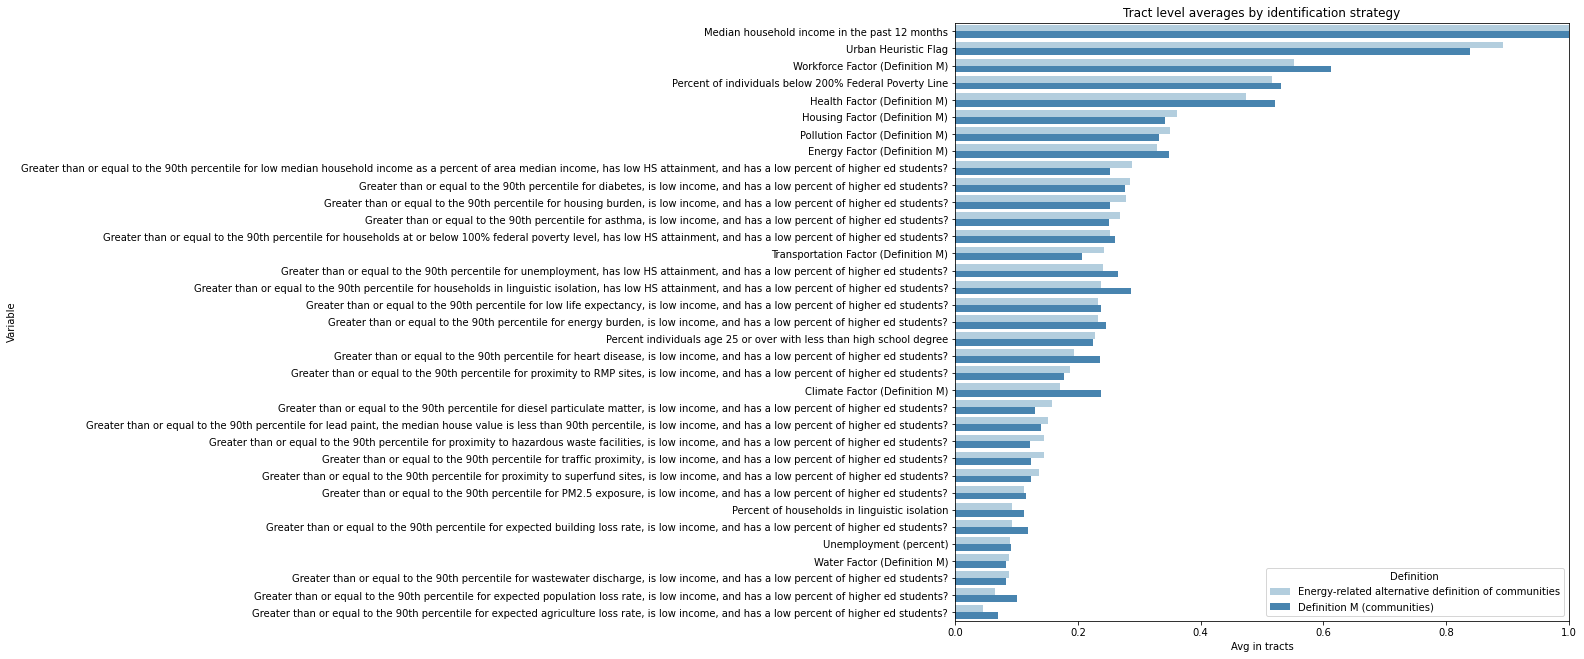

In [19]:
plt.figure(figsize=(11, 11))
sns.barplot(
    y="Variable",
    x="Avg in tracts",
    hue="Definition",
    data=tract_level_by_identification.sort_values(
        by=COMPARATOR_COLUMN, ascending=False
    )
    .stack()
    .reset_index()
    .rename(
        columns={"level_0": "Variable", "level_1": "Definition", 0: "Avg in tracts"}
    ),
    palette="Blues",
)
plt.xlim(0, 1)
plt.title("Tract level averages by identification strategy")
plt.savefig(os.path.join(OUTPUT_DATA_PATH, "tract_lvl_avg.jpg"), bbox_inches="tight")

In [20]:
# papermill_description=Tract_stats_grouped
tract_level_by_grouping = utils.get_tract_level_grouping(
    joined_frame,
    SCORE_COLUMN,
    COMPARATOR_COLUMN,
    ADDITIONAL_DEMO_COLUMNS + DEMOGRAPHIC_COLUMNS,
)

tract_level_by_grouping_formatted = utils.format_multi_index_for_excel(
    tract_level_by_grouping
)

## Population-weighted stats

In [25]:
joined_frame["check"] = (
    joined_frame["Percent individuals age 25 or over with less than high school degree"]
    * joined_frame["Total population"]
)

joined_frame.groupby(COMPARATOR_COLUMN)[["check", "Total population"]].sum()

,check,Total population
Energy-related alternative definition of communities,,
False,"26,879,503.260","265,381,690.000"
True,"13,936,829.884","60,908,281.000"


In [22]:
# papermill_description=Population_stats
population_weighted_stats = pd.concat(
    [
        utils.construct_weighted_statistics(
            joined_frame,
            COMPARATOR_COLUMN,
            DEMOGRAPHIC_COLUMNS + ADDITIONAL_DEMO_COLUMNS,
            TOTAL_POPULATION_COLUMN,
        ),
        utils.construct_weighted_statistics(
            joined_frame,
            SCORE_COLUMN,
            DEMOGRAPHIC_COLUMNS + ADDITIONAL_DEMO_COLUMNS,
            TOTAL_POPULATION_COLUMN,
        ),
    ],
    axis=1,
)
population_weighted_stats

,not Energy-related alternative definition of communities,Energy-related alternative definition of communities,not Definition M (communities),Definition M (communities)
Median household income in the past 12 months,"75,493.300","42,989.351","80,464.789","41,941.314"
Urban Heuristic Flag,0.804,0.890,0.819,0.823
Percent of individuals below 200% Federal Poverty Line,0.273,0.501,0.233,0.520
Percent individuals age 25 or over with less than high school degree,0.101,0.229,0.082,0.232
Unemployment (percent),0.050,0.084,0.044,0.086
Percent of households in linguistic isolation,0.045,0.101,0.028,0.124
"Greater than or equal to the 90th percentile for expected population loss rate, is low income, and has a low percent of higher ed students?",0.019,0.060,0.000,0.094
"Greater than or equal to the 90th percentile for expected agriculture loss rate, is low income, and has a low percent of higher ed students?",0.016,0.049,0.000,0.077
"Greater than or equal to the 90th percentile for expected building loss rate, is low income, and has a low percent of higher ed students?",0.022,0.092,0.000,0.123
"Greater than or equal to the 90th percentile for PM2.5 exposure, is low income, and has a low percent of higher ed students?",0.019,0.120,0.000,0.132


## Print to excel

In [23]:
# papermill_description=Writing_excel
utils.write_single_comparison_excel(
    OUTPUT_EXCEL,
    population,
    tract_level_by_identification,
    population_weighted_stats,
    tract_level_by_grouping_formatted,
)

# Additional analysis for Anjuli

In [33]:
joined_frame.groupby([SCORE_COLUMN, COMPARATOR_COLUMN])[
    ADDITIONAL_DEMO_COLUMNS
].mean().loc[(True,)].T

Energy-related alternative definition of communities,False,True
Urban Heuristic Flag,0.781,0.903
Percent of individuals below 200% Federal Poverty Line,0.510,0.555
Percent individuals age 25 or over with less than high school degree,0.204,0.251
Unemployment (percent),0.086,0.098
Percent of households in linguistic isolation,0.118,0.105
"Greater than or equal to the 90th percentile for expected population loss rate, is low income, and has a low percent of higher ed students?",0.114,0.083
"Greater than or equal to the 90th percentile for expected agriculture loss rate, is low income, and has a low percent of higher ed students?",0.080,0.058
"Greater than or equal to the 90th percentile for expected building loss rate, is low income, and has a low percent of higher ed students?",0.121,0.117
"Greater than or equal to the 90th percentile for PM2.5 exposure, is low income, and has a low percent of higher ed students?",0.092,0.143
"Greater than or equal to the 90th percentile for energy burden, is low income, and has a low percent of higher ed students?",0.205,0.296


In [34]:
joined_frame.groupby([SCORE_COLUMN, COMPARATOR_COLUMN])[
    ADDITIONAL_DEMO_COLUMNS
].mean().loc[(True,)].T.tail(8)

Energy-related alternative definition of communities,False,True
Climate Factor (Definition M),0.254,0.217
Energy Factor (Definition M),0.289,0.419
Transportation Factor (Definition M),0.122,0.309
Housing Factor (Definition M),0.242,0.461
Pollution Factor (Definition M),0.238,0.446
Water Factor (Definition M),0.057,0.112
Health Factor (Definition M),0.454,0.604
Workforce Factor (Definition M),0.537,0.703


In [40]:
missing_factors = (
    joined_frame.groupby([SCORE_COLUMN, COMPARATOR_COLUMN])[ADDITIONAL_DEMO_COLUMNS]
    .sum()
    .loc[(True,)]
    .T.tail(8)
    .sort_values(by=False)
)

missing_factors

Energy-related alternative definition of communities,False,True
Water Factor (Definition M),734.000,"1,195.000"
Transportation Factor (Definition M),"1,567.000","3,292.000"
Pollution Factor (Definition M),"3,049.000","4,756.000"
Housing Factor (Definition M),"3,099.000","4,916.000"
Climate Factor (Definition M),"3,255.000","2,318.000"
Energy Factor (Definition M),"3,703.000","4,466.000"
Health Factor (Definition M),"5,813.000","6,435.000"
Workforce Factor (Definition M),"6,882.000","7,498.000"


In [41]:
missing_factors.to_csv(OUTPUT_DATA_PATH + "/missing_factors.csv", index=False)